In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas
from scipy.io import loadmat

In [2]:
# load zebrafish tailbeat data and stimulus LED location information
data = pandas.read_csv('./behavioral_data/DataFrameTailBeats.csv') # raw tail beat response data 
summary_data = loadmat('./behavioral_data/Summary_data.mat') # pre-computed means and stdevs
masks = loadmat('./behavioral_data/Stimulus_masks.mat') # masks indicating which LEDs are on for each stimulus

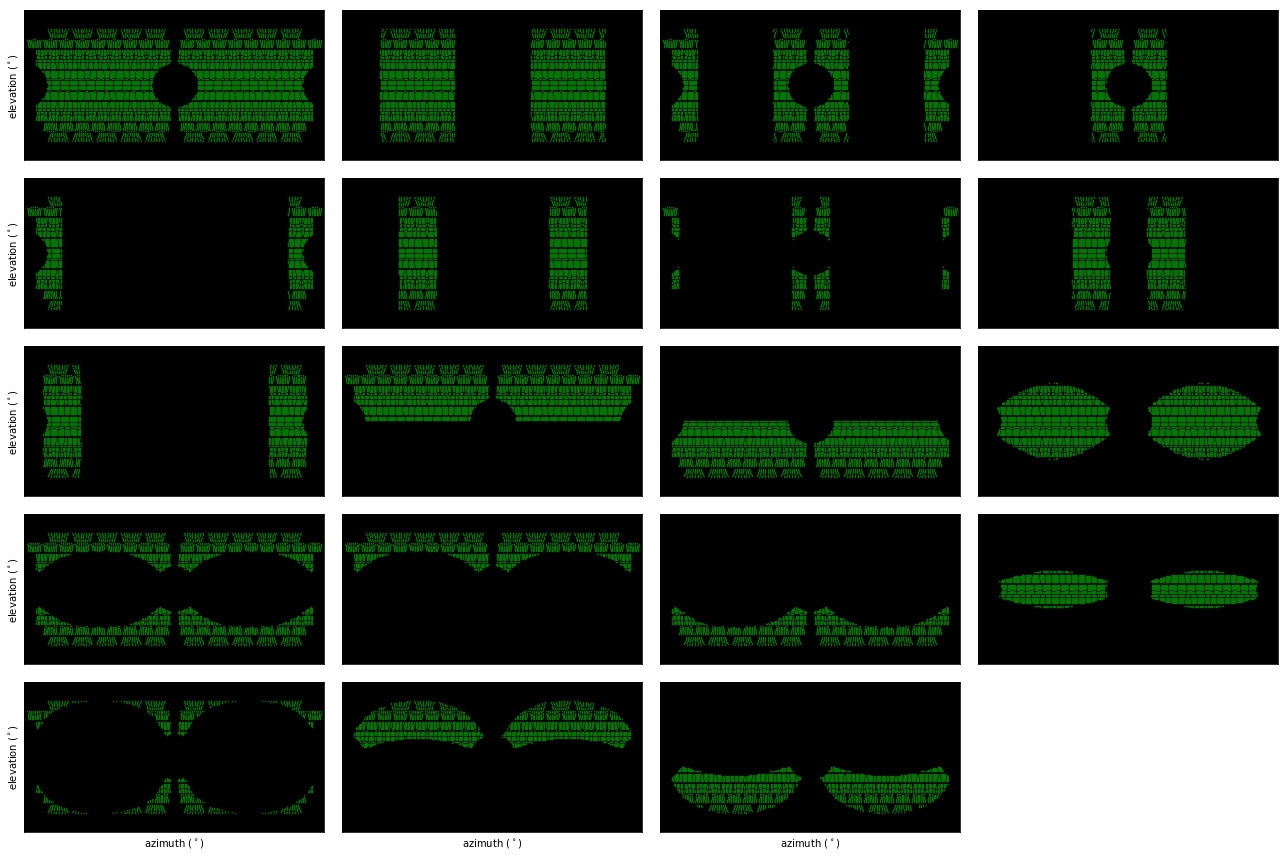

In [3]:
# show LED illumination pattern for all stimuli
LED_azimuths = summary_data['out'][0][0][0][0][0][0] # LED coordinates
LED_elevations = summary_data['out'][0][0][0][0][0][1]

fig = plt.figure(figsize=(18,12),facecolor='w')
for stim in range(1,20):
    plt.subplot(5,4,stim)
    mask = np.copy(masks['forward'][0][0][stim][0][0][0]).astype('float')
    mask[mask==0] = np.nan
    plt.scatter(LED_azimuths,LED_elevations*mask,color='g',s=.25)
    plt.xlim(-180,180)
    plt.ylim(-90,90)
    plt.gca().set_facecolor('k')
    plt.gca().set_aspect(1)
    azes = [-180,-90,0,90,180]
    els = [-90,-40,0,40,90]
    plt.xticks([])#(azes,[str(az) for az in azes])
    plt.yticks([])#(els,[str(el) for el in els])
    if stim%4 == 1:
        plt.ylabel('elevation ($^\circ$)')
    if stim > 16:
        plt.xlabel('azimuth ($^\circ$)')
plt.tight_layout()

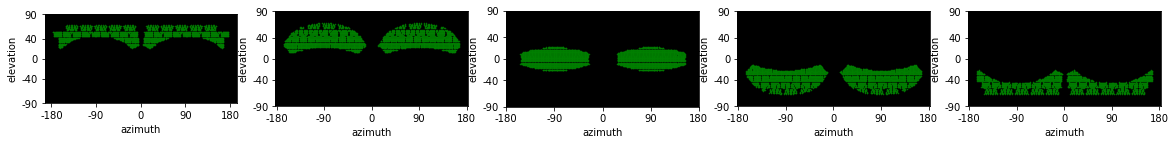

In [4]:
# show LED illumination pattern for 5 stimuli used for the elevation-only analysis
nstims = 5
fiveset = [14,18,16,19,15] 

fig = plt.figure(figsize=(20,5),facecolor='w')
for nstim in range(nstims):
    plt.subplot(1,nstims,nstim+1)
    stim = fiveset[nstim]
    mask = np.copy(masks['forward'][0][0][stim][0][0][0]).astype('float')
    mask[mask==0] = np.nan
    plt.scatter(LED_azimuths,LED_elevations*mask,color='g',s=.25)
    plt.gca().set_facecolor('k')
    plt.gca().set_aspect(1)
    azes = [-180,-90,0,90,180]
    els = [-90,-40,0,40,90]
    plt.xticks(azes,[str(az) for az in azes])
    plt.yticks(els,[str(el) for el in els])
    plt.xlabel('azimuth')
    plt.ylabel('elevation')

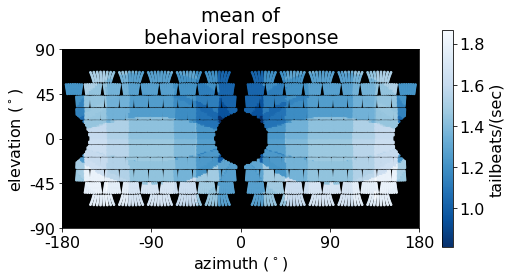

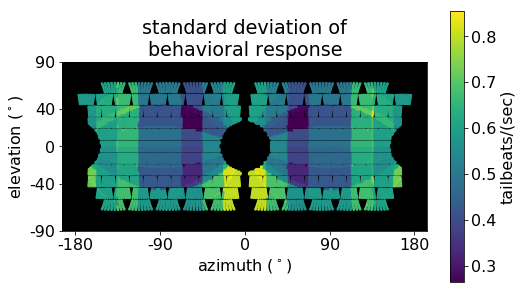

<Figure size 1296x360 with 0 Axes>

In [6]:
# plot normalized mean and stdev of tailbeats for all stimuli
direction = 0 # forward motion direction
resp_means = summary_data['out'][0][0][direction][0][0][2]
resp_stddevs = summary_data['out'][0][0][direction][0][0][3]

plt.rcParams['font.size'] = '16'

# mean
fig = plt.figure(figsize=(8,4),facecolor='w')
plt.scatter(LED_azimuths,LED_elevations,c=resp_means,cmap='Blues_r',s=3)
plt.colorbar(label='tailbeats/(sec)') # I changed this to sec*LED from sec to match paper, but now scale does not match
plt.gca().set_facecolor('k')
plt.gca().set_aspect(1)
azes = [-180,-90,0,90,180]
els = [-90,-45,0,45,90]
plt.ylim(-90,90)
plt.xlim(-180,180)
plt.xticks(azes,[str(az) for az in azes])
plt.yticks(els,[str(el) for el in els])
plt.title('mean of\nbehavioral response')
plt.xlabel('azimuth ($^\circ$)')
plt.ylabel('elevation ($^\circ$)')

# standard devation
fig = plt.figure(figsize=(18,5),facecolor='w')
plt.subplot(1,2,1)
plt.scatter(LED_azimuths,LED_elevations,c=resp_stddevs,s=3)
plt.colorbar(label='tailbeats/(sec)')
plt.gca().set_facecolor('k')
plt.gca().set_aspect(1)
azes = [-180,-90,0,90,180]
els = [-90,-40,0,40,90]
plt.xticks(azes,[str(az) for az in azes])
plt.yticks(els,[str(el) for el in els])
plt.xlabel('azimuth ($^\circ$)')
plt.ylabel('elevation ($^\circ$)')
plt.title('standard deviation of\nbehavioral response')
fig = plt.figure(figsize=(18,5),facecolor='w')

In [7]:
# calculate response as a function of elevation from raw data
nfish = 10
nrepeats = 5
timestep = 6

fiveLEDs = np.zeros(5) # grabbing responses for the 5 elevation-isolating stimuli
fiveresponses = np.nan*np.ones([nfish,nstims,nrepeats]) 
fivex = np.zeros(nstims)
fiveweights = np.ones(nstims)
direction = 'forward'

datelist = data.date.unique() # list of experiment dates
datelist.sort()

azimuths = masks['forward'][0][0][0][0][0][0]
elevations = masks['forward'][0][0][0][0][0][1]

fish = -1 # data from 10 fish, but only 8 have valid trials for this condition
for date in datelist[:5]:
    for fishid in [1,2]:
        fish = fish + 1
        for nstim in range(nstims):
            stim = fiveset[nstim]
            mask = np.copy(masks['forward'][0][0][stim][0][0][0]).astype('float')
            mask[mask==0] = np.nan
            fivex[nstim] = np.nanmean(mask*elevations)
            fiveweights[nstim] = 4174/np.nansum(mask)
            fiveLEDs[nstim] = np.nansum(mask)
            for repeat in [1,2,3]:
                tailbeats = np.array(data[np.logical_and.reduce([data['stimulus'] == f's{stim:02.0f}', 
                                          data['stimulus_direction'] == direction,
                                          data['date'] == date,
                                          data['fish'] == fishid,
                                          data['repeat'] == repeat])]['tail_beat'])
                if len(tailbeats) != 1:
                    continue
                fiveresponses[fish,nstim,repeat] = tailbeats[0]/timestep
            fiveresponses[fish,nstim,4] = np.nanmean(fiveresponses[fish,nstim,1:4])

/Users/emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


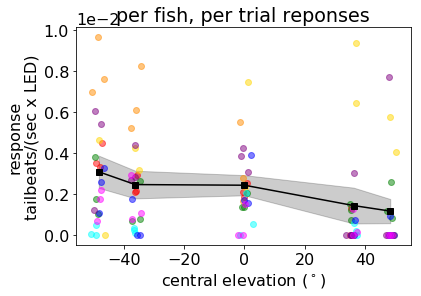

In [8]:
# plot individual fish responses as a function of LED elevation
fishcolors = ['k','red','darkorange','gold','g','cyan','b','indigo','purple','magenta','gray']
for fish in range(nfish):
    for trial in range(4):
        plt.plot(fivex+np.random.randn(len(fivex)),[fiveresponses[fish,i,trial]/fiveLEDs[i] for i in range(len(fivex))],'o',alpha=.5,color=fishcolors[fish])
fivemeans_norm = np.array([np.nanmean(fiveresponses[:,i,4]/fiveLEDs[i]) for i in range(len(fivex))])
fivestderr_norm = np.array([np.sqrt(np.nanvar(fiveresponses[:,i,4]/fiveLEDs[i]))/np.sqrt(8) for i in range(len(fivex))])
plt.plot(fivex,fivemeans_norm,'-sk')
plt.fill_between(fivex,fivemeans_norm-fivestderr_norm,fivemeans_norm+fivestderr_norm,color='k',alpha=.2)
plt.xlabel('central elevation ($^\circ$)')
plt.ylabel('response\ntailbeats/(sec x LED)')
plt.title('per fish, per trial reponses')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))